# Parte 1 Cargar los datos

In [46]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import datasets
from sklearn.base import clone

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
np.random.seed(0)

In [19]:
diabetes = load_diabetes(as_frame=True)

In [ ]:
features_df = pd.DataFrame(diabetes['data'])
target_df = pd.DataFrame(diabetes['target'])

diabetes_df = pd.concat([features_df,target_df], axis= 1)

diabetes_df

Los predictores significan:

- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- s1 tc, total serum cholesterol
- s2 ldl, low-density lipoproteins
- s3 hdl, high-density lipoproteins
- s4 tch, total cholesterol / HDL
- s5 ltg, possibly log of serum triglycerides level
- s6 glu, blood sugar level

In [48]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,442.0,-3.639623e-16,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727
sex,442.0,1.309912e-16,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680
bmi,442.0,-8.013951e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555
bp,442.0,1.289818e-16,0.047619,-0.112400,-0.036656,-0.005671,0.035644,0.132044
s1,442.0,-9.042540e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914
s2,442.0,1.301121e-16,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788
s3,442.0,-4.563971e-16,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179
s4,442.0,3.863174e-16,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234
s5,442.0,-3.848103e-16,0.047619,-0.126097,-0.033249,-0.001948,0.032433,0.133599
s6,442.0,-3.398488e-16,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612


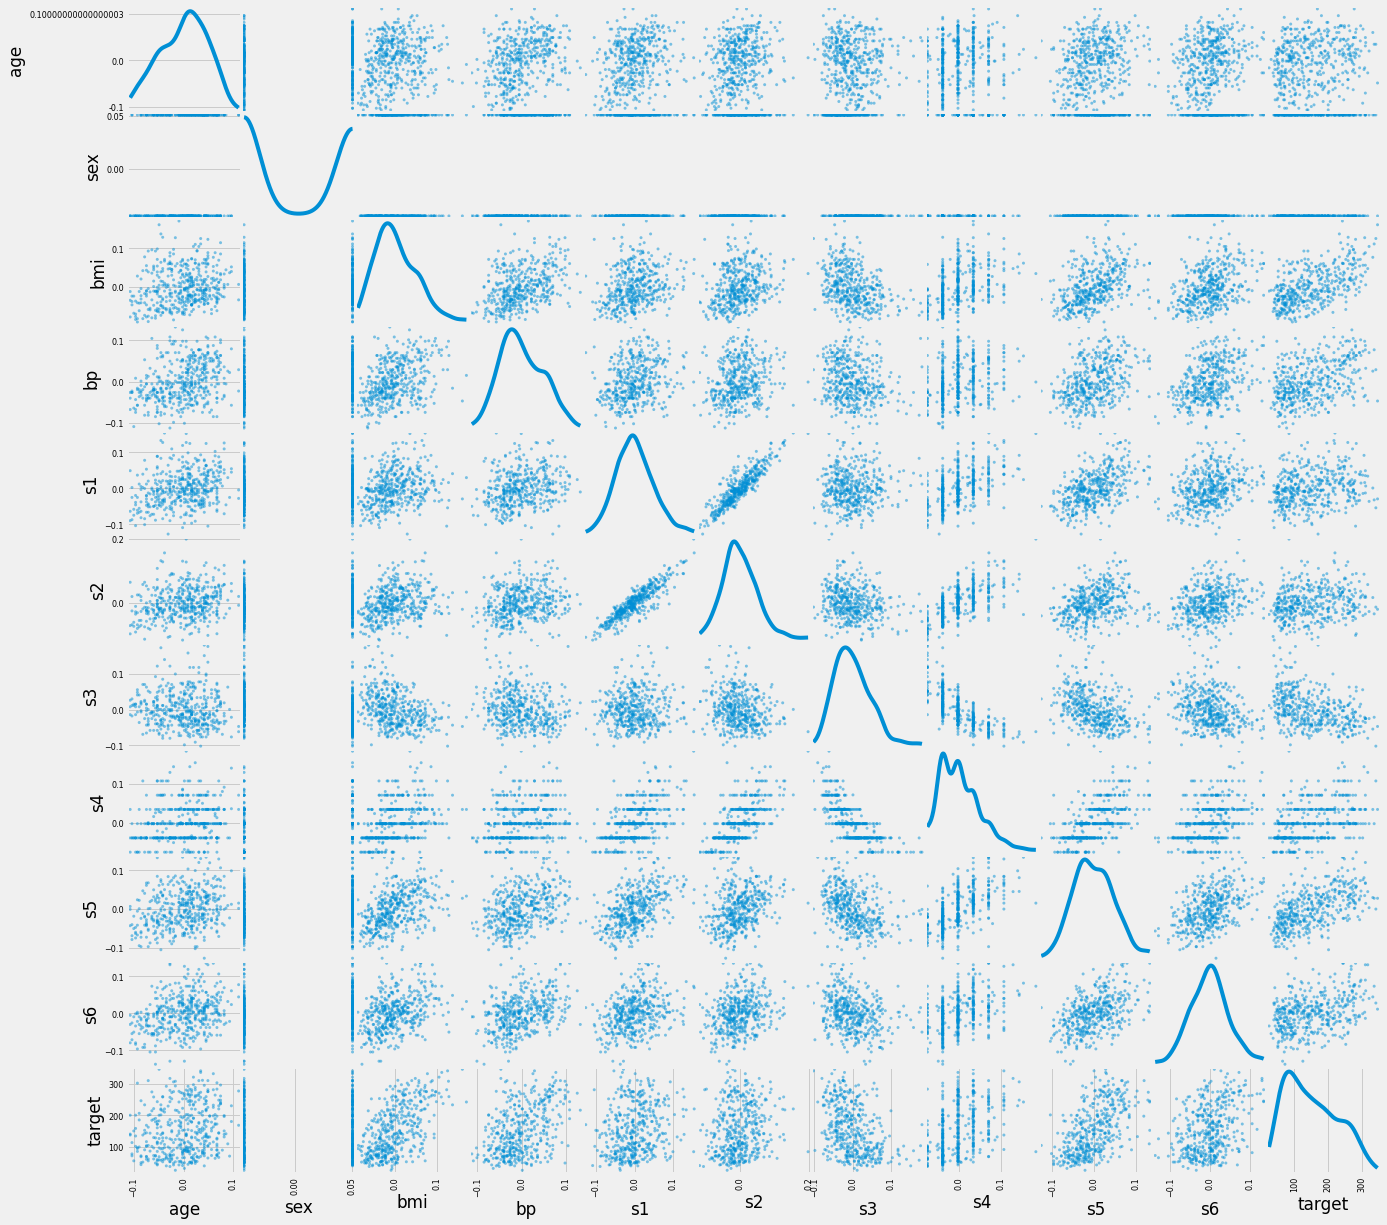

In [52]:
pd.plotting.scatter_matrix(diabetes_df,figsize=(20,20), diagonal='kde');

Si hay líneas verticales u horizontales, te puede indicar la existencia de grupos.

Si hay agrupaciones no tan marcadas pero con cierta dirección (+,-), puede indicar tendencia

S4 parece tener cierta importancia porque a la izquierda y derecha, arriba y abajo de la diagonal, existen grupos. Por tanto, podría ser un predictor muy relevante

In [53]:
X = features_df
y = target_df

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        shuffle=True,
                                                        test_size=0.3,
                                                        random_state=40)

In [59]:
lir_ridge = Ridge(alpha= 0.5)
lir_ridge.fit(X_train, y_train)
y_hat = lir_ridge.predict(X_test)

print('R^2 score: ', r2_score(y_test,y_hat))
print('MSE: ', mean_squared_error(y_test,y_hat))


R^2 score:  0.4072010484349503
MSE:  3655.0457873921832


### Cross Validation

In [63]:
def cv(X, y, estimator, folds, seed=154):
    '''
    Parámetros
    ---------
    X: np.array 
        Matriz de predictores
    y: np.array 
        Matriz de variable predicha
    estimator: sklearn model object
        El estimador a utilizar
    folds: int
        Número de dobleces para la validación cruzada
    seed: int
        Semilla para poder replicar
    Arroja
    ---------
    train_cv_errors, test_cv_errors: tuple de arrays
    Los errores de los sets de entrenamiento y prueba para cada doblez de la validación cruzada
    '''
    X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.33,random_state=seed)
    kf = KFold(n_splits=folds)
    test_cv_errors, train_cv_errors = np.empty(folds), np.empty(folds)

    for j, (train_index,test_index) in enumerate(kf.split(X_train)):
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_tst = X_train[test_index]
        y_tst = y_train[test_index]

        #Esto se hace para poder adecuarse conforma al tipo de estimador establecido: puede ser ridge, lasso, etc. 
        estimator_clone = clone(estimator)
        estimator_clone.fit(X_tr, y_tr)

        #Train
        y_tr_hat = estimator_clone.predict(X_tr)
        mse_train = mean_squared_error(y_tr,y_tr_hat)
        train_cv_errors[j] = mse_train

        #Test
        y_tst_hat = estimator_clone.predict(X_tst)
        mse_test = mean_squared_error(y_tst,y_tst_hat)
        test_cv_errors[j] = mse_test
    
    return train_cv_errors, test_cv_errors

def train_at_various_alphas(X,y,model,alphas,n_folds=10,**kwargs):
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))), columns = alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))), columns = alphas)

    for alpha in alphas:
        cv_errors_train[alpha], cv_errors_test[alpha] = cv(X,y,model(alpha), n_folds)
    
    return cv_errors_train, cv_errors_test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.33,random_state=40)
train_cv_errors, test_cv_errors = cv(np.array(X_train), np.array(y_train), Ridge(alpha=0.5), folds = 10)
train_cv_errors, test_cv_errors

(array([3008.04761427, 3238.33856446, 3096.82184622, 3099.1613868 ,
        3144.62801348, 3134.10034376, 3142.38420607, 3070.00309229,
        3046.69913663, 3162.43090259]),
 array([3866.24824645, 2172.33288752, 3651.44948114, 3118.52469159,
        2765.53768091, 3264.50171334, 3259.68069339, 4074.49754212,
        4015.82013686, 2565.62328904]))

In [62]:
print(train_cv_errors.mean(), test_cv_errors.mean())

3114.2615106564635 3275.4216362368015


In [ ]:
ridge_alphas = np.logspace(-2, 4, num=250)

ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(np.array(X_train), np.array(y_train), Ridge, ridge_alphas)

#Cada renglón representa un doblez de validación cruzada, cada columna es un valor de alpha
ridge_cv_errors_train, ridge_cv_errors_test

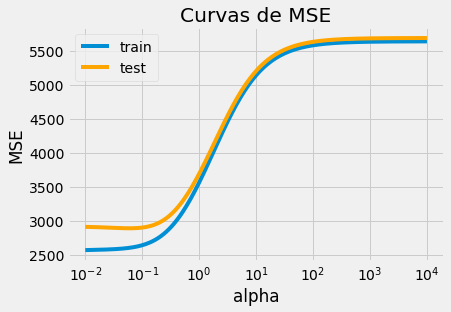

In [68]:
ridge_cv_errors_train.mean(), ridge_cv_errors_test.mean()

fig, ax = plt.subplots()
ax.semilogx(ridge_alphas, ridge_cv_errors_train.mean(), label = 'train')
ax.semilogx(ridge_alphas, ridge_cv_errors_test.mean(), label = 'test', color='orange')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')
ax.set_title('Curvas de MSE')
ax.legend();

In [70]:
ridge_cv_errors_test_min = ridge_cv_errors_test.mean()[ridge_cv_errors_test.mean() == ridge_cv_errors_test.mean().min()]

optimal_alpha = ridge_cv_errors_test_min.index

optimal_alpha

Float64Index([0.05903157047645996], dtype='float64')

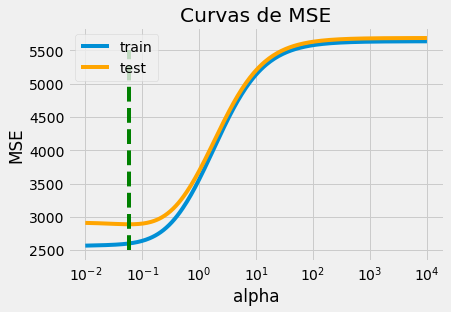

In [73]:
fig, ax = plt.subplots()
ax.semilogx(ridge_alphas, ridge_cv_errors_train.mean(), label = 'train')
ax.semilogx(ridge_alphas, ridge_cv_errors_test.mean(), label = 'test', color='orange')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')
ax.set_title('Curvas de MSE')
ax.legend()
ax.vlines(x=optimal_alpha, ymin=2500, ymax=5500, colors='green', linestyles='dashed');

Ahora, teniendo el óptimo de alpha, se analizan los valores de beta vía múltiples modelos de regresión Ridge

Se define la función necesaria para almacenar los coeficientes de los modelos con las distintas alphas

In [72]:
def ridge_coef_calc(X,y,alphas):
    n_alphas = len(alphas)
    n_features = X.shape[1] #Número de predictores (columnas)
    coefs = np.zeros((n_alphas, n_features)) #Para almacenar los valores de beta de los distintos modelos 

    for i, alpha in enumerate(alphas):
        #Fitting del modelo
        model = Ridge(alpha = alpha).fit(X,y)
        #guardando los coeficientes del modelo de acuerdo con el alpha
        coefs[i]=model.coef_
    
    return coefs

In [74]:
coefs_ridge = ridge_coef_calc(X_train, y_train, ridge_alphas)
coefs_ridge

array([[ 1.75143050e+00, -2.19930781e+02,  5.88876390e+02, ...,
         1.25201641e+02,  6.28528305e+02,  4.00492279e+01],
       [ 1.86004326e+00, -2.19651272e+02,  5.88451901e+02, ...,
         1.24521225e+02,  6.24800701e+02,  4.02205644e+01],
       [ 1.97171235e+00, -2.19360112e+02,  5.87999383e+02, ...,
         1.23864075e+02,  6.21114214e+02,  4.04004529e+01],
       ...,
       [ 2.62564857e-02,  6.32908156e-03,  7.15330724e-02, ...,
         4.75286951e-02,  6.79715281e-02,  4.31760915e-02],
       [ 2.48398355e-02,  5.98782001e-03,  6.76729516e-02, ...,
         4.49642213e-02,  6.43036828e-02,  4.08464495e-02],
       [ 2.34995948e-02,  5.66494194e-03,  6.40210967e-02, ...,
         4.25380771e-02,  6.08337207e-02,  3.86424721e-02]])

In [75]:
coefs_ridge.shape

(250, 10)

Son 250 renglones porque fueron 250 alphas calculadas; y son 10 columnas porque ese es el número de predictores

Graficando las betas de Ridge bajo las distintas betas

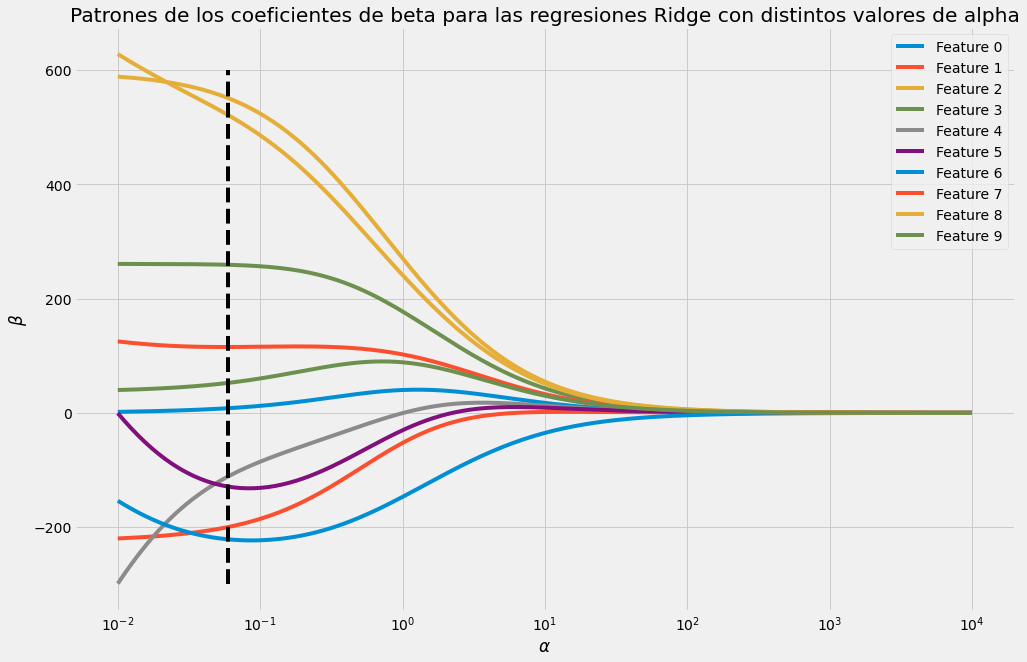

In [76]:
fig, ax = plt.subplots(figsize=(15,10))
i = 0
while i < 10:
    ax.semilogx(ridge_alphas, coefs_ridge[:,i], label = 'Feature {}'.format(i))
    i+=1
ax.plot([optimal_alpha, optimal_alpha], [-300,600], color='black', linestyle='dashed')
ax.set_title('Patrones de los coeficientes de beta para las regresiones Ridge con distintos valores de alpha')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')
ax.legend(loc='upper right');

Del gráfico anterior, con el alpha óptima que minimiza los errores, ves que las betas no necesariamente convergen a 0. Esto indica que aún teniendo el óptimo en los errores en el set de entrenamiento y de prueba, tienes aún la posibilidad de interpretar los coeficientes de beta.

Ahora, se realiza la regresión LASSO.

La regresión LASSO* es útil para imponer la dispersión en los coeficientes. Es decir, es preferible si creemos que muchas de las características no son en absoluto relevantes para predecir el objetivo.*

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,test_size=0.3,random_state=40)
#Random_state te permite replicar el ejercicio después; onda random seed

In [ ]:
lasso_alphas = np.logspace(-2, 4, num=250)

lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(np.array(X_train), np.array(y_train), Lasso, lasso_alphas)

#Cada renglón representa un doblez de validación cruzada, cada columna es un valor de alpha
lasso_cv_errors_train, lasso_cv_errors_test 

In [79]:
lasso_cv_errors_test_min = lasso_cv_errors_test.mean()[lasso_cv_errors_test.mean() == lasso_cv_errors_test.mean().min()]

optimal_alpha = lasso_cv_errors_test_min.index
optimal_alpha

Float64Index([0.08704804787452367], dtype='float64')

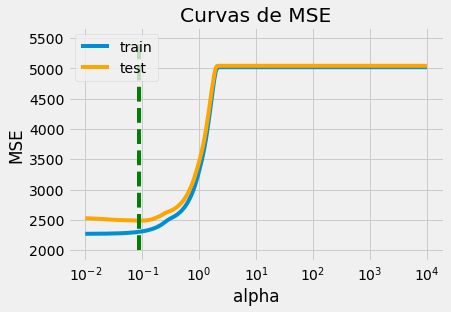

In [81]:
fig, ax = plt.subplots()
ax.semilogx(lasso_alphas, lasso_cv_errors_train.mean(), label = 'train')
ax.semilogx(lasso_alphas, lasso_cv_errors_test.mean(), label = 'test', color='orange')
ax.set_xlabel('alpha')
ax.set_ylabel('MSE')
ax.set_title('Curvas de MSE')
ax.legend()
ax.vlines(x=optimal_alpha, ymin=2000, ymax=5500, colors='green', linestyles='dashed');

In [82]:
def lasso_coef_calc(X,y,alphas):
    n_alphas = len(alphas)
    n_features = X.shape[1] #Número de predictores (columnas)
    coefs = np.zeros((n_alphas, n_features)) #Para almacenar los valores de beta de los distintos modelos 

    for i, alpha in enumerate(alphas):
        #Fitting del modelo
        model = Lasso(alpha = alpha).fit(X,y)
        #guardando los coeficientes del modelo de acuerdo con el alpha
        coefs[i]=model.coef_
    
    return coefs

In [83]:
coefs_lasso = lasso_coef_calc(X_train, y_train, lasso_alphas)
coefs_lasso

array([[  13.48589037, -215.92010275,  585.37298267, ...,  107.47769106,
         606.79328117,   30.55956983],
       [  13.22759522, -215.37184483,  585.23353621, ...,  105.41256691,
         606.45396054,   30.36792586],
       [  12.9545638 , -214.79230766,  585.08613405, ...,  103.22962313,
         606.09528096,   30.16534821],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

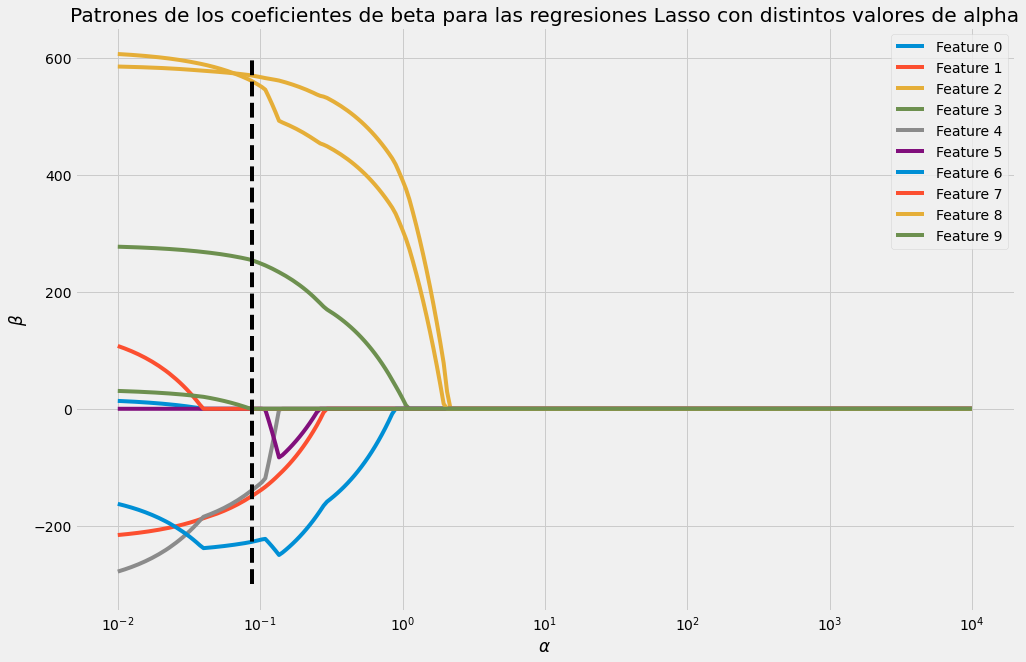

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
i = 0
while i < 10:
    ax.semilogx(lasso_alphas, coefs_lasso[:,i], label = 'Feature {}'.format(i))
    i+=1
ax.plot([optimal_alpha, optimal_alpha], [-300,600], color='black', linestyle='dashed')
ax.set_title('Patrones de los coeficientes de beta para las regresiones Lasso con distintos valores de alpha')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('$\\beta$')
ax.legend(loc='upper right');

El gráfico anterior indica que, bajo alpha óptima (donde se minimizan los errores), hay varias variables predictoras que no aportan mucho (irrelevantes en la predicción de y); y por tanto, deberían tornarse en cero.

Realizando una comparación entre el desempeño de LASSO y Ridge

In [85]:
print('Alpha óptima de LASSO:', lasso_cv_errors_test_min)
print('Alpha óptima de Ridge:', ridge_cv_errors_test_min)

Alpha óptima de LASSO: 0.087048    2485.943821
dtype: float64
Alpha óptima de Ridge: 0.059032    2887.927074
dtype: float64


### Con Ridge:

In [86]:
model = Ridge(alpha = 0.059032)
model.fit(X_train, y_train)

Ridge(alpha=0.059032)

In [87]:
yhat = model.predict(X_test)
mse = mean_squared_error(y_test, yhat)
print(mse)

3644.0241745257918


### Con Lasso:

In [88]:
model = Lasso(alpha = 0.087048)
model.fit(X_train, y_train)

Lasso(alpha=0.087048)

In [89]:
yhat = model.predict(X_test)
mse = mean_squared_error(y_test, yhat)
print(mse)

3650.853814371182


### Comparando con una regresión lineal no regularizada

In [90]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [91]:
yhat = model.predict(X_test)
mse = mean_squared_error(y_test, yhat)
print(mse)

3675.861521743378


El modelo que se elegiría sería un modelo Ridge. Antes de ponerlo en producción, vería si hay otra alternativa con mejor desempeño.